# Self-Driving Car Engineer Nanodegree


## Project: **Advanced Finding Lane Lines** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/ricardo-0x07/CarND-Advanced-Lane-Lines/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/571/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, see [this forum post](https://carnd-forums.udacity.com/cq/viewquestion.action?spaceKey=CAR&id=29496372&questionTitle=finding-lanes---import-cv2-fails-even-though-python-in-the-terminal-window-has-no-problem-with-import-cv2) for more troubleshooting tips.**  

## Import Packages

In [1]:
#importing some useful packages
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage.feature import hog
import glob
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
# NOTE: the next import is only valid 
# for scikit-learn version <= 0.17
# if you are using scikit-learn >= 0.18 then use this:
# from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label
%matplotlib inline


## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [2]:
import os
import glob
dirs = os.listdir("data/vehicles/")
cars = []
print(dirs)
for image_type in dirs:
    cars.extend(glob.glob('data/vehicles/'+ image_type+'/*'))
    
print('Number of Vehicles Images found', len(cars))

with open('data/vehicles/cars.txt', 'w') as f:
    for fn in cars:
        f.write(fn+'\n')


dirs = os.listdir("data/non-vehicles/")
notcars = []
print(dirs)
for image_type in dirs:
    notcars.extend(glob.glob('data/non-vehicles/'+ image_type+'/*'))
    
print('Number of Non-Vehicles Images found', len(notcars))

with open('data/non-vehicles/notcars.txt', 'w') as f:
    for fn in notcars:
        f.write(fn+'\n')


['.DS_Store', 'cars.txt', 'GTI_Far', 'GTI_Left', 'GTI_MiddleClose', 'GTI_Right', 'KITTI_extracted']
Number of Vehicles Images found 8792
['.DS_Store', 'Extras', 'GTI', 'notcars.txt']
Number of Non-Vehicles Images found 8968


/Applications/anaconda/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


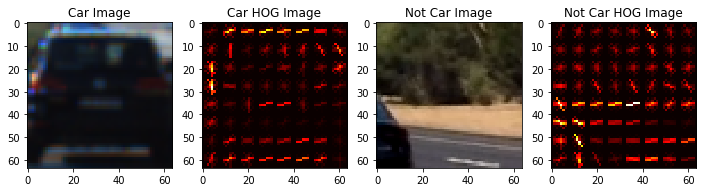

In [3]:
from vehicle_detection import Vehicle_Detection
vd = Vehicle_Detection(ystart=400,threshold_factor=15, heat_threshold=26, window=64, scales=[1,1.5])
# Choose random car / not-car indices
car_ind = np.random.randint(0,len(cars))
notcar_ind = np.random.randint(0,len(notcars))

# Read in car / not-car image
car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])

# Define feature parameters
color_space = 'RGB' # #ANY OTHER
orient = 9
pix_per_call = 8
cell_per_block =2
hog_channel =0
spacial_size = (16,16)
hist_bins = 16
spacial_feat = True
hist_feat = True
hog_feat = True

car_features, car_hog_image = vd.single_img_features_train(car_image, color_space=color_space, spatial_size=spacial_size,
                            hist_bins=hist_bins, orient=orient, 
                            pix_per_cell=pix_per_call, cell_per_block=cell_per_block, hog_channel=hog_channel,
                            spatial_feat=spacial_feat, hist_feat=hist_feat, hog_feat=hog_feat)

notcar_features, notcar_hog_image = vd.single_img_features_train(notcar_image, color_space=color_space, spatial_size=spacial_size,
                            hist_bins=hist_bins, orient=orient, 
                            pix_per_cell=pix_per_call, cell_per_block=cell_per_block, hog_channel=hog_channel,
                            spatial_feat=spacial_feat, hist_feat=hist_feat, hog_feat=hog_feat)
images = [car_image, car_hog_image, notcar_image, notcar_hog_image]
titles = ['Car Image', 'Car HOG Image', 'Not Car Image', 'Not Car HOG Image']
fig = plt.figure(figsize=(12,3))
vd.visualise(fig,1,4,images,titles)
# f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(12,3))
# ax1.imshow(car_image)
# ax1.set_title('Car Image', fontsize=10)
# ax2.imshow(car_hog_image, cmap='hot')
# ax2.set_title('Car HOG Image', fontsize=10)

# ax3.imshow(notcar_image)
# ax3.set_title('Not Car Image', fontsize=10)
# ax4.imshow(notcar_hog_image, cmap='hot')
# ax4.set_title('Not Car HOG Image', fontsize=10)

In [4]:
# from vehicle_detection import Vehicle_Detection
import time
import pickle
# vd = Vehicle_Detection()

# Define feature parameters
color_space = 'YCrCb' # #ANY OTHER
orient = 9
pix_per_cell = 8
cell_per_block =2
hog_channel ='ALL'
spatial_size = (16,16)
hist_bins = 16
spatial_feat = True
hist_feat = True
hog_feat = True

t=time.time()
n_samples = 1000

# Choose random car / not-car indices
car_indxs = np.random.randint(0,len(cars),n_samples)
notcar_indxs = np.random.randint(0,len(notcars),n_samples)

# Read in car / not-car image
test_cars = cars#np.array(cars)[car_indxs]
test_notcars = notcars#np.array(notcars)[notcar_indxs]

car_features = vd.extract_features(test_cars, color_space=color_space, spatial_size=spacial_size,
                         hist_bins=hist_bins, orient=orient,
                         pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                         spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)

notcar_features = vd.extract_features(test_notcars, color_space=color_space, spatial_size=spacial_size,
                         hist_bins=hist_bins, orient=orient,
                         pix_per_cell=pix_per_call, cell_per_block=cell_per_block, hog_channel=hog_channel,
                         spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)
print(time.time()-t, ' Seconds to compute features...')
X = np.vstack((car_features, notcar_features)).astype(np.float)
# Fit a per column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)),np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0,100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.1, random_state=rand_state)

print('Using: ', orient, 'orientations,', pix_per_cell, 'pixels per cell', cell_per_block, 'cells per block,', hist_bins,
     'histogram bins, and', spacial_size, 'spatial sampling')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC
svc = LinearSVC()
# Check the learning time of the SVC
t=time.time()
svc.fit(X_train,y_train)
# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["clf"] = svc
dist_pickle["scaler"] = X_scaler
dist_pickle["color_space"] = color_space
dist_pickle["orient"] = orient
dist_pickle["pix_per_cell"] = pix_per_cell
dist_pickle["cell_per_block"] = cell_per_block
dist_pickle["spatial_size"] = spatial_size
dist_pickle["hog_channel"] = hog_channel
dist_pickle["hist_bins"] = hist_bins
dist_pickle["spatial_feat"] = spatial_feat
dist_pickle["hist_feat"] = hist_feat
dist_pickle["hog_feat"] = hog_feat
pickle.dump( dist_pickle, open( "model/dist_pickle.p", "wb" ) )

print(round(time.time()-t, 2), ' Seconds to train SVC...')
# Check the score of the SVC
print('Test accuracy of svc = ', round(svc.score(X_test,y_test),4))



/Applications/anaconda/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


491.1941511631012  Seconds to compute features...
Using:  9 orientations, 8 pixels per cell 2 cells per block, 16 histogram bins, and (16, 16) spatial sampling
Feature vector length: 6156
112.16  Seconds to train SVC...
Test accuracy of svc =  0.9949


In [4]:
import time
import pickle
# vd = Vehicle_Detection()

# Define feature parameters
color_space = 'YCrCb' # #ANY OTHER
orient = 9
pix_per_cell = 8
cell_per_block =2
hog_channel ='ALL'
spatial_size = (16,16)
hist_bins = 16
spatial_feat = True
hist_feat = True
hog_feat = True

dist_pickle = pickle.load( open("model/dist_pickle.p", "rb" ) )
svc = dist_pickle["clf"]
X_scaler = dist_pickle["scaler"]
orient = dist_pickle["orient"]
pix_per_cell = dist_pickle["pix_per_cell"]
cell_per_block = dist_pickle["cell_per_block"]
spatial_size = dist_pickle["spatial_size"]
hist_bins = dist_pickle["hist_bins"]


['.DS_Store', 'Extras', 'GTI', 'notcars.txt']
1.5042030811309814  Seconds to run, total windos =  912
0.3578760623931885  Seconds to run, total windos =  294
0.9998440742492676  Seconds to run, total windos =  912
0.36469006538391113  Seconds to run, total windos =  294
0.9116878509521484  Seconds to run, total windos =  912
0.31252384185791016  Seconds to run, total windos =  294
0.864677906036377  Seconds to run, total windos =  912
0.3266561031341553  Seconds to run, total windos =  294
0.7971680164337158  Seconds to run, total windos =  912
0.305142879486084  Seconds to run, total windos =  294
0.8122749328613281  Seconds to run, total windos =  912
0.3107631206512451  Seconds to run, total windos =  294


ValueError: num must be 1 <= num <= 16, not 17

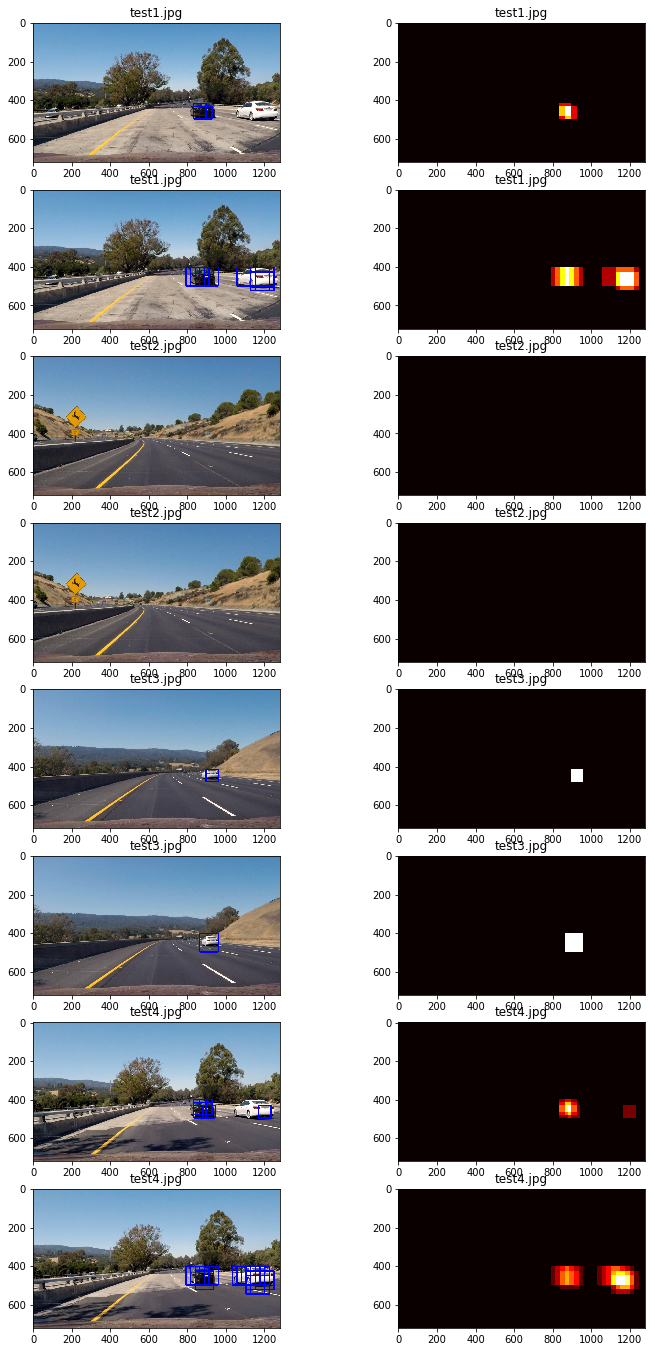

In [5]:
import os
import warnings
warnings.filterwarnings('ignore')
print(dirs)
image_files = glob.glob('test_images/test*.jpg')

out_images = []
out_map = []
out_titles =[]
out_boxes = []
#consider a narrower swath in y
y_start_stop = [400, 656]
# scale = 1.5
scales = [1,1.5]
# Iterate over test images
for img_src in image_files:
    for scale in scales:
        img_boxes =[]
        t=time.time()
        count = 0
        img = mpimg.imread(img_src)
        draw_img = np.copy(img)
        # Make a heatmap of zero
        heatmap = np.zeros_like(img[:,:,0])
        img = img.astype(np.float32)/255
        img_tosearch = img[y_start_stop[0]:y_start_stop[1],:,:]
        ctrans_tosearch = vd.convert_color(img_tosearch, conv='RGB2YCrCb')
        if(scale != 1):
            imshape = ctrans_tosearch.shape
            ctrans_tosearch = cv2.resize(ctrans_tosearch, ((np.int(imshape[1]/scale)),(np.int(imshape[0]/scale))))

        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]

        # Define blocks and steps as above
        nxblocks = np.int((ch1.shape[1]//pix_per_cell) - 1)
        nyblocks = np.int((ch1.shape[0]//pix_per_cell) - 1)

        nfeat_per_window = orient*cell_per_block**2
        window = 64
        nblocks_per_window = (window//pix_per_cell) -1
        cells_per_step = 2 # Instead of overlap define howmany cells to step
        nxsteps = (nxblocks - nblocks_per_window)//cells_per_step
        nysteps = (nyblocks - nblocks_per_window)//cells_per_step

        # Compute individual channel HOG features for the entire image
        hog1 = vd.get_hog_features(ch1, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=False)
        hog2 = vd.get_hog_features(ch2, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=False)    
        hog3 = vd.get_hog_features(ch3, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=False)


        for xb in range(nxsteps):
            for yb in range(nysteps):
                count += 1
                ypos = yb*cells_per_step
                xpos = xb*cells_per_step
                # Extract HOG for this patch
                hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
                hog_features = np.hstack((hog_feat1,hog_feat2,hog_feat3))

                xleft= xpos*pix_per_cell
                ytop= ypos*pix_per_cell

                # Extract the image patch
                subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window,xleft:xleft+window], (64,64))

                # Get color features
                spatial_features = vd.bin_spatial(subimg, size=spatial_size)
                hist_features = vd.color_hist(subimg, nbins=hist_bins)

                # Scale features and make a prediction 
                test_features = X_scaler.transform(np.hstack((spatial_features,hist_features,hog_features)))
                test_prediction = svc.predict(test_features)

                if(test_prediction == 1):
                    xbox_left = np.int(xleft*scale)
                    ytop_draw = np.int(ytop*scale)
                    win_draw = np.int(window*scale)
                    cv2.rectangle(draw_img, (xbox_left, ytop_draw+y_start_stop[0]),(xbox_left+win_draw,ytop_draw+win_draw+y_start_stop[0]),(0, 0, 255),6)
                    img_boxes.append(((xbox_left, ytop_draw+y_start_stop[0]),(xbox_left+win_draw,ytop_draw+win_draw+y_start_stop[0])))
                    heatmap[ytop_draw+y_start_stop[0]:ytop_draw+win_draw+y_start_stop[0], xbox_left:xbox_left+win_draw] += 1

        print(time.time()-t, ' Seconds to run, total windos = ', count)
        cv2.imwrite('output_images/'+ img_src.split('/')[1], draw_img)
        out_images.append(draw_img)
        out_titles.append(img_src[12:])
        out_titles.append(img_src[12:])
        out_images.append(heatmap)
        out_boxes.append(img_boxes)

#             f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
#             ax1.imshow(draw_img)
#             ax1.set_title('Boxes Image', fontsize=30)
#             plt.imshow(heatmap, cmap='hot')
#             ax2.set_title('Heat Map', fontsize=30)
                
            
fig = plt.figure(figsize=(12,24))
vd.visualise(fig,8,2,out_images,out_titles)


In [ ]:
# ystart = [400,400,390,370]
# ystop = [464,518,646,646]
# scale = 1.5
# windows_sizes = [64,128,192,256]

# image = mpimg.imread('test_images/test6.jpg')
# for i in range(len(windows_sizes)):
#     out_img, hot_windows, all_windows = find_cars(image, ystart[i], ystop[i], scale, clf, train_scaler, orient, pix_per_cell, cell_per_block, spatial, histbins,windows_sizes[i])
#     plt.imshow(out_img)
#     plt.show()

1.103667974472046  Seconds to run
1.2534589767456055  Seconds to run
1.0715699195861816  Seconds to run
1.086244821548462  Seconds to run
1.0793330669403076  Seconds to run
1.108119010925293  Seconds to run


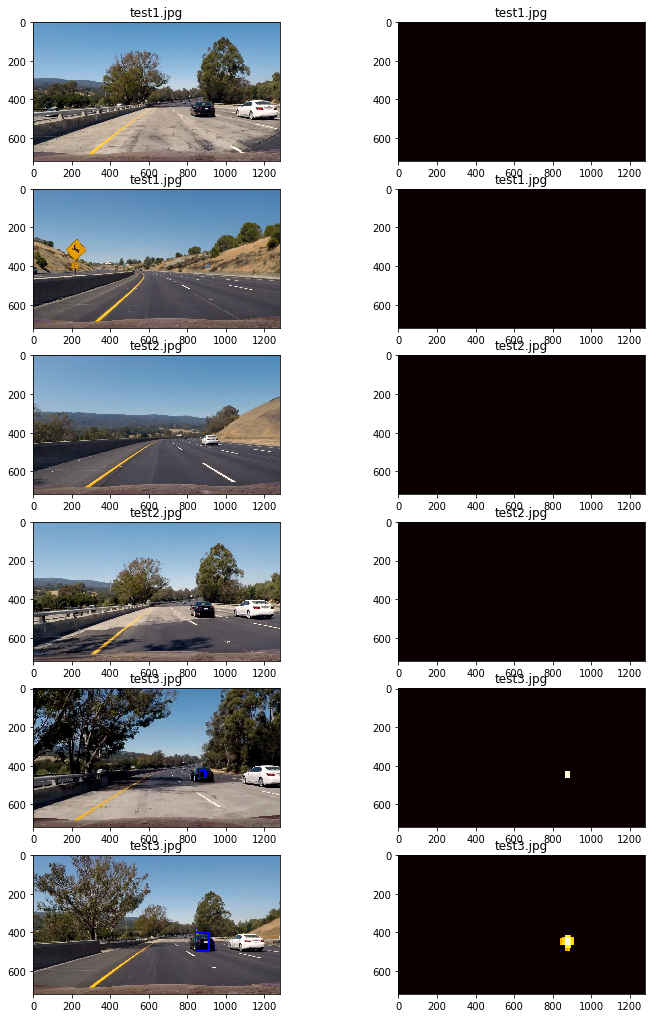

In [6]:
import os
import warnings
from scipy.ndimage.measurements import label
warnings.filterwarnings('ignore')

out_images = []
out_map = []
# out_titles =[]
out_boxes = []
#consider a narrower swath in y
ystart = 400
ystop = 656
scales = [1,1.5]
for img_src in image_files:
    for scale in vd.scales:
        t=time.time()
        img = mpimg.imread(img_src)
        out_img, heatmap = vd.find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
        vd.heatmaps.append(heatmap)
    intergrated_heat_maps = np.sum(vd.heatmaps, axis=0)
#     threshold_heat_map = vd.apply_threshold(intergrated_heat_maps,vd.heat_threshold)
    threshold_heat_map = vd.apply_threshold(intergrated_heat_maps,10)
    labels = label(threshold_heat_map)

    draw_image = vd.draw_labeled_bboxes(np.copy(img), labels)
    out_images.append(draw_image)
    out_images.append(intergrated_heat_maps)
    print(time.time()-t, ' Seconds to run')
    cv2.imwrite('output_images/'+ img_src.split('/')[1], draw_img)

fig = plt.figure(figsize=(12,24))
vd.visualise(fig,8,2,out_images,out_titles)

In [7]:
def process_image(img):
    out_image, heat_map = vd.find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    draw_image = vd.draw_labeled_bboxes(np.copy(img), labels)
    # Draw bounding boxes on a copy of the image
#     draw_image = vd.draw_labeled_bboxes(np.copy(img), labels)
    return draw_image

In [ ]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [ ]:
output_video = 'output_images/project_video.mp4'
clip1 = VideoFileClip("project_video.mp4")
video_clip = clip1.fl_image(vd.process_image) #NOTE: this function expects color images!!
%time video_clip.write_videofile(output_video, audio=False)

[MoviePy] >>>> Building video output_images/project_video.mp4
[MoviePy] Writing video output_images/project_video.mp4


 96%|█████████▌| 1213/1261 [1:26:09<03:17,  4.10s/it]

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_video))

['.DS_Store', 'test1.jpg', 'test2.jpg', 'test3.jpg', 'test4.jpg', 'test5.jpg', 'test6.jpg']
0.0 1.0


/Applications/anaconda/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


0.3630800247192383  Seconds to process one image searching 57  Windows
0.0 1.0
0.3273289203643799  Seconds to process one image searching 57  Windows
0.0 1.0
0.3070681095123291  Seconds to process one image searching 57  Windows
0.0 1.0
0.2922861576080322  Seconds to process one image searching 57  Windows
0.0 1.0
0.29375720024108887  Seconds to process one image searching 57  Windows
0.0 1.0
0.29604005813598633  Seconds to process one image searching 57  Windows


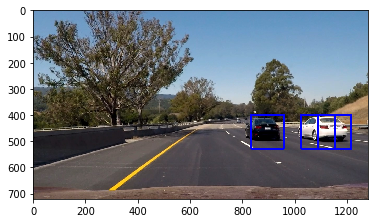

In [14]:
import os
print(dirs)
image_files = glob.glob('test_images/test*.jpg')
images = []
titles = []
y_start_stop = [400, 656] # Min and max in y to search in slide_window()
x_start_stop = [None, None] # Min and max in x to search in slide_window()
overlap = 0.5

for image_name in image_files:
    t1 = time.time()
    imagex = mpimg.imread(image_name)
    draw_img = np.copy(imagex)
    imagex = imagex.astype(np.float32)/255
    print(np.min(imagex), np.max(imagex))
    windows = vd.slide_window(imagex, x_start_stop=x_start_stop, y_start_stop=y_start_stop,
                     xy_window=(128, 128), xy_overlap=(overlap, overlap))
    hot_windows = vd.search_windows(imagex, windows, svc, X_scaler, color_space=color_space,
                       spatial_size=spatial_size, hist_bins=hist_bins, orient=orient,
                       pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                       hog_channel=hog_channel, spatial_feat=spatial_feat,
                       hist_feat=hist_feat, hog_feat=hog_feat)
    window_image = vd.draw_boxes(draw_img, hot_windows, color=(0, 0, 255), thick=6)
    images.append(window_image)
    titles.append('')
    print(time.time()-t1, ' Seconds to process one image searching', len(windows), ' Windows')
#     result = vd.process_image(imagex)
    cv2.imwrite('output_images/'+ image_name.split('/')[1], window_image)
    plt.imshow(window_image)
    plt.xlim(0, 1280)
    plt.ylim(720, 0)

# fig = plt.figure(figsize=(12,18), dpi=300)
# vd.visualise(fig,5,2,images,titles)
#     result = vd.process_image(imagex)
#     cv2.imwrite('output_images/'+ image_name, result)
#     plt.imshow(result)
#     plt.xlim(0, 1280)
#     plt.ylim(720, 0)


## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

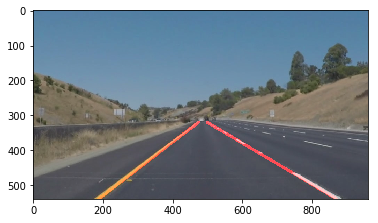

In [258]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.
# Read in and grayscale the image
# plt.imshow(image)
# for file in dirs:
# print(file)
for image_name in dirs:
    imagex = mpimg.imread('test_images/'+ image_name)
    gray = grayscale(imagex)

    # Define a kernel size and apply Gaussian smoothing
    kernel_size = 3
    blur_gray = gaussian_blur(gray, kernel_size)

    # Define our parameters for Canny and apply
    low_threshold = 200
    high_threshold = 255
    edges = canny(blur_gray, low_threshold, high_threshold)

    # This time we are defining a four sided polygon to mask
    imshape = image.shape
#     print(imshape)
    vertices = np.array([[(150,imshape[0]),(400, 360), (imshape[1]-350, 30), (imshape[1]-60,imshape[0])]], dtype=np.int32)
    masked_edges = region_of_interest(edges, vertices)
    # cv2.fillPoly(mask, vertices, ignore_mask_color)
    # masked_edges = cv2.bitwise_and(edges, mask)
#     plt.imshow(masked_edges)
    # Define the Hough transform parameters
    # Make a blank the same size as our image to draw on
    rho = 1 # distance resolution in pixels of the Hough grid
    theta = np.pi/360 # angular resolution in radians of the Hough grid
    threshold = 1     # minimum number of votes (intersections in Hough grid cell)
    min_line_len = 7 #minimum number of pixels making up a line
    max_line_gap = 3    # maximum gap in pixels between connectable line segments
    line_image = np.copy(image)*0 # creating a blank to draw lines on

    # Run Hough on edge detected image
    # Output "lines" is an array containing endpoints of detected line segments
    lines = hough_lines(masked_edges, rho, theta, threshold, min_line_len, max_line_gap)
    # Create a "color" binary image to combine with line image
    color_edges = np.dstack((lines, lines, lines)) 

    # Draw the lines on the edge image
    lines_edges = weighted_img(lines, imagex, α=0.8, β=1., λ=0.)
    cv2.imwrite('test_images_output/'+ image_name, lines_edges)
    plt.imshow(lines_edges)

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an `import error` when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt. Also, check out [this forum post](https://carnd-forums.udacity.com/questions/22677062/answers/22677109) for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://carnd-forums.udacity.com/display/CAR/questions/26218840/import-videofileclip-error) for more troubleshooting tips across operating systems.**

In [214]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [215]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    # imagex = mpimg.imread('test_images/'+ image_name)
    gray = grayscale(image)

    # Define a kernel size and apply Gaussian smoothing
    kernel_size = 3
    blur_gray = gaussian_blur(gray, kernel_size)

    # Define our parameters for Canny and apply
    low_threshold = 200
    high_threshold = 255
    edges = canny(blur_gray, low_threshold, high_threshold)

    # This time we are defining a four sided polygon to mask
    imshape = image.shape
    vertices = np.array([[(150,imshape[0]),(400, 360), (imshape[1]-350, 360), (imshape[1]-60,imshape[0])]], dtype=np.int32)
    masked_edges = region_of_interest(edges, vertices)
    # cv2.fillPoly(mask, vertices, ignore_mask_color)
    # masked_edges = cv2.bitwise_and(edges, mask)

    # Define the Hough transform parameters
    # Make a blank the same size as our image to draw on
    rho = 1 # distance resolution in pixels of the Hough grid
    theta = np.pi/360 # angular resolution in radians of the Hough grid
    threshold = 1     # minimum number of votes (intersections in Hough grid cell)
    min_line_len = 7 #minimum number of pixels making up a line
    max_line_gap = 3    # maximum gap in pixels between connectable line segments
    line_image = np.copy(image)*0 # creating a blank to draw lines on

    # Run Hough on edge detected image
    # Output "lines" is an array containing endpoints of detected line segments
    lines = hough_video_lines(masked_edges, rho, theta, threshold, min_line_len, max_line_gap)

    # Draw the lines on the edge image
    result = weighted_img(lines, imagex, α=0.8, β=1., λ=0.)
    return result

Let's try the one with the solid white lane on the right first ...

In [292]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|█████████▉| 221/222 [00:07<00:00, 27.93it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 5.03 s, sys: 1.01 s, total: 6.04 s
Wall time: 7.71 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [293]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [297]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|█████████▉| 681/682 [00:21<00:00, 30.97it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 15.8 s, sys: 3.18 s, total: 18.9 s
Wall time: 22.3 s


In [295]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [301]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))